<a href="https://colab.research.google.com/github/ramaoutlook/15-Types-of-Animal-Image-Classification-with-CNN-and-Transfer-Learning-Unified-Mentor-Internship/blob/main/15Types_AnimalClassification_with_CNN_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Animal Image Classification

# Cell 1: Setup and Check GPU
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive, files
import zipfile
import shutil

In [2]:
# Check if GPU is available
print("🔍 Checking GPU availability...")
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available!")
    print("GPU Details:", tf.config.list_physical_devices('GPU'))
else:
    print("⚠️  GPU not available, using CPU")

print(f"TensorFlow version: {tf.__version__}")

🔍 Checking GPU availability...
✅ GPU is available!
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Use dataset from Google Drive
def use_drive_dataset():
    """Use dataset stored in Google Drive and unzip if it's a zip file."""

    drive_dataset_path = '/content/drive/MyDrive/Unified Mentor Internship/dataset.zip'
    extracted_dir_path = '/content' # Directory to extract to

    if os.path.exists(drive_dataset_path):
        print(f"✅ Found dataset in Google Drive: {drive_dataset_path}")

        # Check if the path points to a zip file
        if drive_dataset_path.lower().endswith('.zip'):
            print(f"📦 Found zip file. Unzipping to {extracted_dir_path}...")
            # Create the extraction directory if it doesn't exist
            if not os.path.exists(extracted_dir_path):
                os.makedirs(extracted_dir_path)

            try:
                with zipfile.ZipFile(drive_dataset_path, 'r') as zip_ref:
                    zip_ref.extractall(extracted_dir_path)
                print("✅ Unzipping complete.")
                # Return the path to the extracted directory
                return extracted_dir_path
            except zipfile.BadZipFile:
                print(f"❌ Error: {drive_dataset_path} is not a valid zip file.")
                return None
            except Exception as e:
                print(f"❌ An error occurred during unzipping: {e}")
                return None
        else:
            print("Dataset path is not a zip file. Assuming it's a directory.")
            # If it's not a zip file, assume it's already a directory and return its path
            return drive_dataset_path
    else:
        print(f"❌ Dataset not found at: {drive_dataset_path}")
        print("Please update the path or use the upload method")
        return None

# Choose your method (uncomment the one you want to use)
# DATASET_PATH = upload_dataset_zip()  # Method 1: Upload ZIP
DATASET_PATH = use_drive_dataset()     # Method 2: Use from Drive

# Now DATASET_PATH will be the path to the extracted directory (e.g., '/content')
# or the original directory if the input wasn't a zip file, or None if an error occurred.

if DATASET_PATH:
    print(f"Using dataset from: {DATASET_PATH}")
    # You can now use the DATASET_PATH variable for loading your dataset
    # For example:
    # train_dir = os.path.join(DATASET_PATH, 'train')
    # validation_dir = os.path.join(DATASET_PATH, 'validation')
else:
    print("Failed to get dataset path. Please check the drive path and zip file integrity.")


✅ Found dataset in Google Drive: /content/drive/MyDrive/Unified Mentor Internship/dataset.zip
📦 Found zip file. Unzipping to /content...
✅ Unzipping complete.
Using dataset from: /content


In [5]:
# Cell 4: Import Required Libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [6]:
# Cell 5: Configuration
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
VALIDATION_SPLIT = 0.2

# Define class names
CLASS_NAMES = [
    'Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin',
    'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion',
    'Panda', 'Tiger', 'Zebra'
]

print(f"📊 Configuration:")
print(f"   Image size: {IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Classes: {len(CLASS_NAMES)}")

📊 Configuration:
   Image size: (224, 224)
   Batch size: 32
   Epochs: 25
   Classes: 15


In [8]:
data_path = "/content/dataset"
# Cell 6: Verify Dataset Structure
def verify_colab_dataset(data_path):
    """Verify dataset structure in Colab"""
    if not data_path or not os.path.exists(data_path):
        print(f"❌ Dataset path '{data_path}' does not exist!")
        print("Available directories in /content/:")
        for item in os.listdir('/content/'):
            if os.path.isdir(f'/content/{item}'):
                print(f"   📁 {item}")
        return False

    print(f"✅ Dataset path '{data_path}' found!")
    print(f"📁 Contents of dataset folder:")

    total_images = 0
    found_classes = []

    for item in os.listdir(data_path):
        item_path = os.path.join(data_path, item)
        if os.path.isdir(item_path):
            image_count = len([f for f in os.listdir(item_path)
                             if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))])
            total_images += image_count
            found_classes.append(item)

            status = "✅" if item in CLASS_NAMES else "⚠️ "
            print(f"   {status} {item}: {image_count} images")

    print(f"\n📈 Summary:")
    print(f"   Total images: {total_images}")
    print(f"   Found classes: {len(found_classes)}")
    print(f"   Expected classes: {len(CLASS_NAMES)}")

    return total_images > 0

# Verify the dataset
DATASET_PATH = "/content/dataset"
if DATASET_PATH:
    verify_colab_dataset(DATASET_PATH)

✅ Dataset path '/content/dataset' found!
📁 Contents of dataset folder:
   ✅ Bird: 137 images
   ✅ Panda: 135 images
   ✅ Elephant: 133 images
   ✅ Giraffe: 129 images
   ✅ Lion: 131 images
   ✅ Horse: 130 images
   ✅ Kangaroo: 126 images
   ✅ Deer: 127 images
   ✅ Dolphin: 129 images
   ✅ Zebra: 137 images
   ✅ Tiger: 129 images
   ✅ Bear: 125 images
   ✅ Cow: 131 images
   ✅ Cat: 123 images
   ✅ Dog: 122 images

📈 Summary:
   Total images: 1944
   Found classes: 15
   Expected classes: 15


In [9]:
# Cell 7: Data Preparation
def prepare_colab_data(data_path, img_size, batch_size, validation_split=0.2):
    """Prepare data generators for Colab training"""

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split
    )

    # Only rescaling for validation
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    # Training data generator
    train_generator = train_datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Validation data generator
    val_generator = val_datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    print(f"🎯 Data Summary:")
    print(f"   Training samples: {train_generator.samples}")
    print(f"   Validation samples: {val_generator.samples}")
    print(f"   Number of classes: {train_generator.num_classes}")
    print(f"   Class indices: {train_generator.class_indices}")

    return train_generator, val_generator

# Prepare the data
if DATASET_PATH:
    print("🔄 Preparing data generators...")
    train_generator, val_generator = prepare_colab_data(DATASET_PATH, IMG_SIZE, BATCH_SIZE, VALIDATION_SPLIT)

🔄 Preparing data generators...
Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.
🎯 Data Summary:
   Training samples: 1561
   Validation samples: 383
   Number of classes: 15
   Class indices: {'Bear': 0, 'Bird': 1, 'Cat': 2, 'Cow': 3, 'Deer': 4, 'Dog': 5, 'Dolphin': 6, 'Elephant': 7, 'Giraffe': 8, 'Horse': 9, 'Kangaroo': 10, 'Lion': 11, 'Panda': 12, 'Tiger': 13, 'Zebra': 14}


In [23]:
train_generator

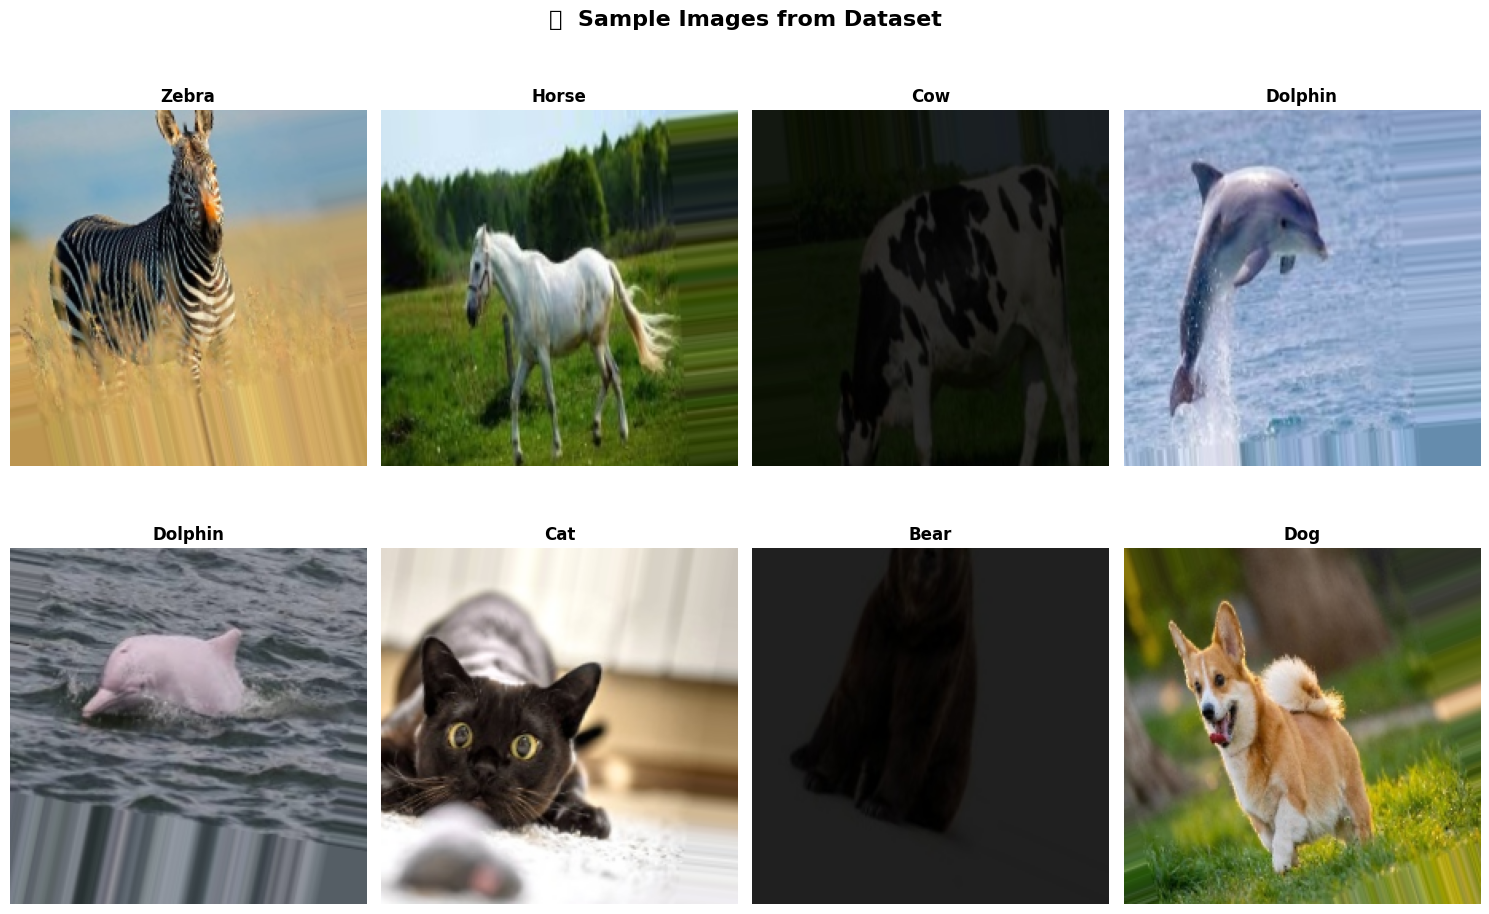

In [10]:
# Cell 8: Visualize Sample Images
def plot_colab_samples(generator, num_images=8):
    """Plot sample images in Colab"""
    plt.figure(figsize=(15, 10))

    # Get a batch of images and labels
    images, labels = next(generator)

    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])

        # Get class name
        class_idx = np.argmax(labels[i])
        class_names_list = list(generator.class_indices.keys())
        class_name = class_names_list[class_idx]

        plt.title(f'{class_name}', fontsize=12, fontweight='bold')
        plt.axis('off')

    plt.suptitle('🖼️  Sample Images from Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Reset generator
    generator.reset()

# Plot sample images
if DATASET_PATH:
    plot_colab_samples(train_generator)


In [11]:
# Cell 9: Build Model for Colab
def build_colab_model(num_classes, img_size, base_model_name='MobileNetV2'):
    """Build optimized model for Colab"""

    print(f"🏗️  Building model with {base_model_name}...")

    # Choose base model (MobileNetV2 is fastest for Colab)
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False,
                          input_shape=(*img_size, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False,
                             input_shape=(*img_size, 3))
    else:  # MobileNetV2 (recommended for Colab)
        base_model = MobileNetV2(weights='imagenet', include_top=False,
                               input_shape=(*img_size, 3))

    # Freeze base model layers
    base_model.trainable = False

    # Add custom classification head
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile with appropriate learning rate for Colab
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
if DATASET_PATH:
    model = build_colab_model(len(train_generator.class_indices), IMG_SIZE)
    model.summary()

🏗️  Building model with MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# Cell 10: Setup Colab Training Callbacks
# Callbacks optimized for Colab
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,  # Reduced patience for faster training
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    min_lr=0.00001,
    verbose=1
)

# Save model checkpoints
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/best_animal_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]
print("✅ Callbacks configured for Colab training")


✅ Callbacks configured for Colab training


In [13]:
# Cell 11: Train the Model in Colab
if DATASET_PATH:
    print("🚀 Starting training...")
    print("📊 Training progress will be displayed below:")

    # Start training with progress tracking
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    print("🎉 Training completed!")

🚀 Starting training...
📊 Training progress will be displayed below:
Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.0796 - loss: 3.0899
Epoch 1: val_accuracy improved from -inf to 0.25849, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 47s 709ms/step - accuracy: 0.0803 - loss: 3.0852 - val_accuracy: 0.2585 - val_loss: 2.3778 - learning_rate: 1.0000e-04
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.2372 - loss: 2.4240
Epoch 2: val_accuracy improved from 0.25849 to 0.56658, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 424ms/step - accuracy: 0.2385 - loss: 2.4215 - val_accuracy: 0.5666 - val_loss: 1.9269 - learning_rate: 1.0000e-04
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.4562 - loss: 1.9200
Epoch 3: val_accuracy improved from 0.56658 to 0.73629, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.4567 - loss: 1.9183 - val_accuracy: 0.7363 - val_loss: 1.5191 - learning_rate: 1.0000e-04
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.5510 - loss: 1.6399
Epoch 4: val_accuracy improved from 0.73629 to 0.76762, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.5517 - loss: 1.6375 - val_accuracy: 0.7676 - val_loss: 1.2036 - learning_rate: 1.0000e-04
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6181 - loss: 1.3482
Epoch 5: val_accuracy improved from 0.76762 to 0.80157, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - accuracy: 0.6188 - loss: 1.3468 - val_accuracy: 0.8016 - val_loss: 0.9832 - learning_rate: 1.0000e-04
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7067 - loss: 1.1319
Epoch 6: val_accuracy improved from 0.80157 to 0.83290, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 414ms/step - accuracy: 0.7066 - loss: 1.1314 - val_accuracy: 0.8329 - val_loss: 0.8359 - learning_rate: 1.0000e-04
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7213 - loss: 0.9957
Epoch 7: val_accuracy improved from 0.83290 to 0.84073, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 392ms/step - accuracy: 0.7215 - loss: 0.9954 - val_accuracy: 0.8407 - val_loss: 0.7439 - learning_rate: 1.0000e-04
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7425 - loss: 0.8805
Epoch 8: val_accuracy improved from 0.84073 to 0.85117, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.7425 - loss: 0.8808 - val_accuracy: 0.8512 - val_loss: 0.6701 - learning_rate: 1.0000e-04
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7539 - loss: 0.8504
Epoch 9: val_accuracy did not improve from 0.85117
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - accuracy: 0.7541 - loss: 0.8496 - val_accuracy: 0.8486 - val_loss: 0.6196 - learning_rate: 1.0000e-04
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7721 - loss: 0.7878
Epoch 10: val_accuracy improved from 0.85117 to 0.86162, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 421ms/step - accuracy: 0.7724 - loss: 0.7871 - val_accuracy: 0.8616 - val_loss: 0.5854 - learning_rate: 1.0000e-04
Epoch 11/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7952 - loss: 0.7073
Epoch 11: val_accuracy did not improve from 0.86162
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.7951 - loss: 0.7074 - val_accuracy: 0.8616 - val_loss: 0.5531 - learning_rate: 1.0000e-04
Epoch 12/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8153 - loss: 0.6583
Epoch 12: val_accuracy improved from 0.86162 to 0.86423, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.8152 - loss: 0.6584 - val_accuracy: 0.8642 - val_loss: 0.5339 - learning_rate: 1.0000e-04
Epoch 13/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8048 - loss: 0.6910
Epoch 13: val_accuracy improved from 0.86423 to 0.87728, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - accuracy: 0.8049 - loss: 0.6903 - val_accuracy: 0.8773 - val_loss: 0.5041 - learning_rate: 1.0000e-04
Epoch 14/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8347 - loss: 0.5864
Epoch 14: val_accuracy did not improve from 0.87728
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - accuracy: 0.8345 - loss: 0.5867 - val_accuracy: 0.8773 - val_loss: 0.4868 - learning_rate: 1.0000e-04
Epoch 15/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8260 - loss: 0.5829
Epoch 15: val_accuracy improved from 0.87728 to 0.87990, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - accuracy: 0.8260 - loss: 0.5828 - val_accuracy: 0.8799 - val_loss: 0.4774 - learning_rate: 1.0000e-04
Epoch 16/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7949 - loss: 0.6488
Epoch 16: val_accuracy did not improve from 0.87990
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 402ms/step - accuracy: 0.7955 - loss: 0.6475 - val_accuracy: 0.8799 - val_loss: 0.4694 - learning_rate: 1.0000e-04
Epoch 17/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8371 - loss: 0.5665
Epoch 17: val_accuracy did not improve from 0.87990
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.8373 - loss: 0.5660 - val_accuracy: 0.8773 - val_loss: 0.4531 - learning_rate: 1.0000e-04
Epoch 18/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8514 - loss: 0.5183
Epoch 18: val_accuracy did not improve from 0.87990
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.8514 - loss: 0.5184 - val_accuracy: 0.8747 - val_loss: 0.4505 - learning_rate: 1.0000e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 405ms/step - accuracy: 0.8551 - loss: 0.4864 - val_accuracy: 0.8825 - val_loss: 0.4334 - learning_rate: 1.0000e-04
Epoch 20/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8533 - loss: 0.4690
Epoch 20: val_accuracy did not improve from 0.88251
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 381ms/step - accuracy: 0.8533 - loss: 0.4691 - val_accuracy: 0.8799 - val_loss: 0.4365 - learning_rate: 1.0000e-04
Epoch 21/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8610 - loss: 0.4380
Epoch 21: val_accuracy did not improve from 0.88251
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 0.8609 - loss: 0.4384 - val_accuracy: 0.8799 - val_loss: 0.4262 - learning_rate: 1.0000e-04
Epoch 22/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8667 - loss: 0.4564
Epoch 22: val_accuracy improved from 0.88251 to 0.89034, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - accuracy: 0.8667 - loss: 0.4568 - val_accuracy: 0.8903 - val_loss: 0.4242 - learning_rate: 1.0000e-04
Epoch 23/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8736 - loss: 0.4380
Epoch 23: val_accuracy improved from 0.89034 to 0.89295, saving model to /content/best_animal_model.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 417ms/step - accuracy: 0.8736 - loss: 0.4378 - val_accuracy: 0.8930 - val_loss: 0.4211 - learning_rate: 1.0000e-04
Epoch 24/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8601 - loss: 0.4798
Epoch 24: val_accuracy did not improve from 0.89295
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.8603 - loss: 0.4791 - val_accuracy: 0.8877 - val_loss: 0.4052 - learning_rate: 1.0000e-04
Epoch 25/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9010 - loss: 0.3865
Epoch 25: val_accuracy did not improve from 0.89295
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - accuracy: 0.9006 - loss: 0.3871 - val_accuracy: 0.8851 - val_loss: 0.4073 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 24.
🎉 Training completed!


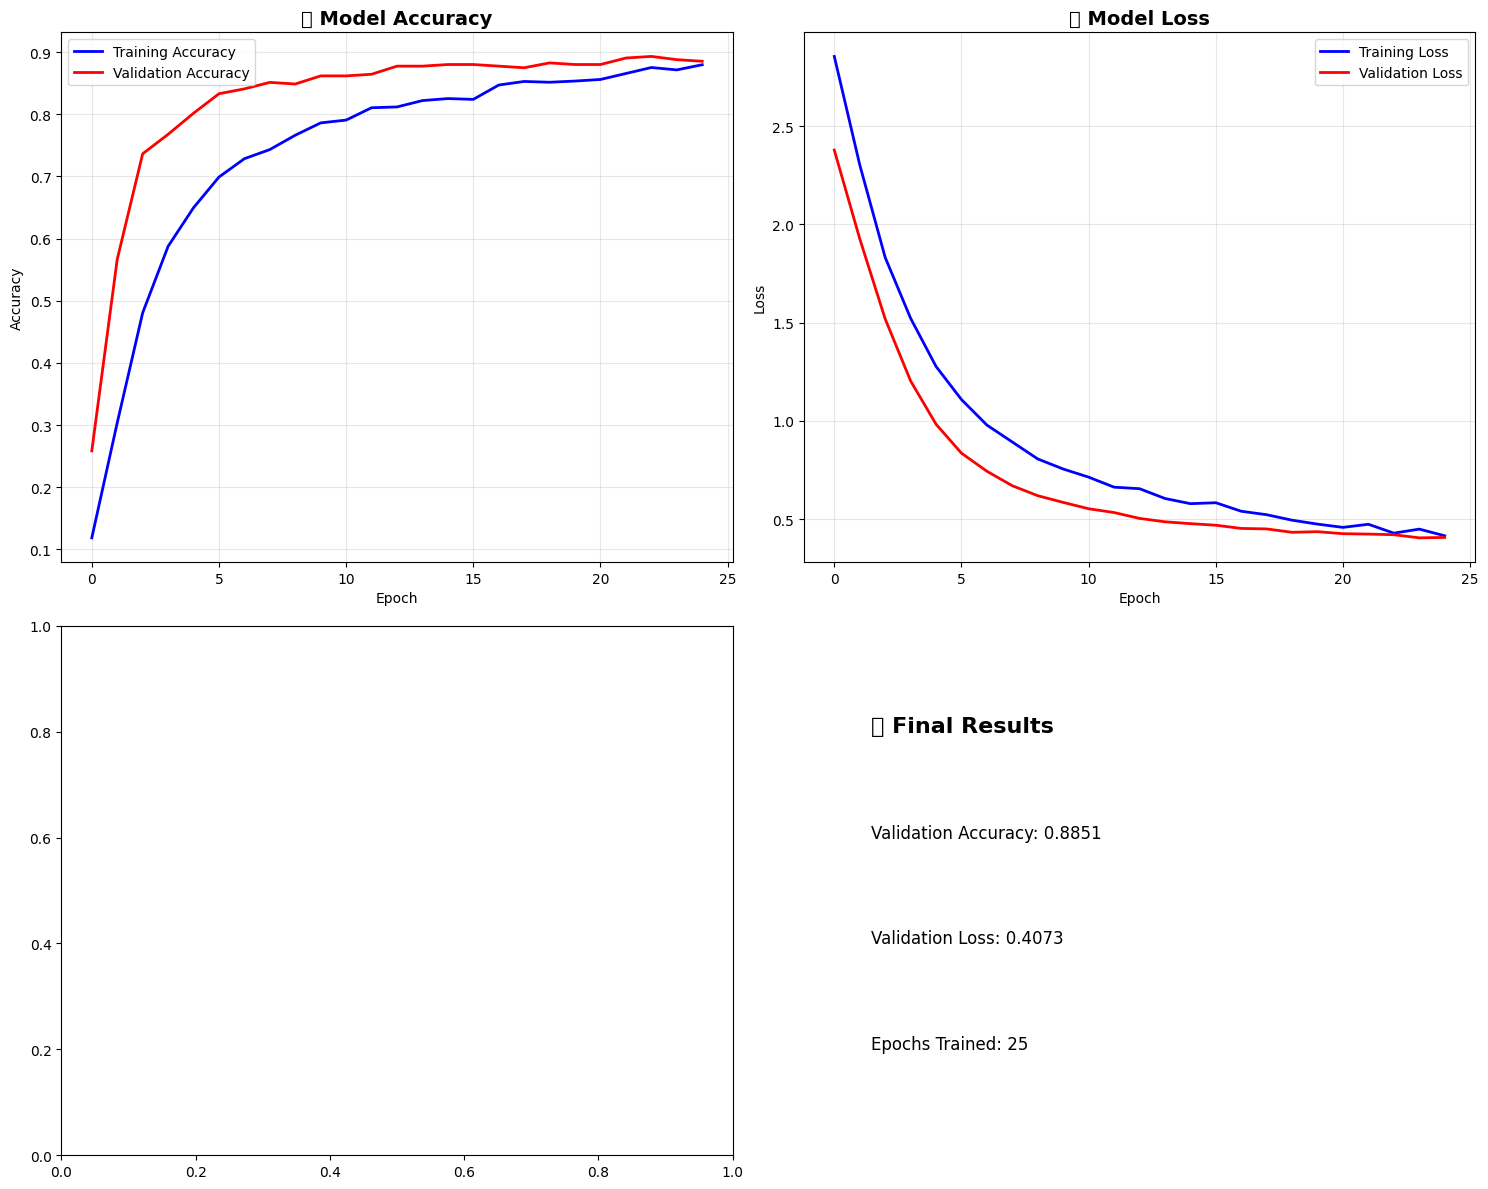

In [14]:
# Cell 12: Visualize Training Results
def plot_colab_history(history):
    """Plot training history with enhanced visualization for Colab"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Accuracy plot
    axes[0,0].plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0,0].plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0,0].set_title('📈 Model Accuracy', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Loss plot
    axes[0,1].plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0,1].plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0,1].set_title('📉 Model Loss', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Learning rate (if available)
    if 'lr' in history.history:
        axes[1,0].plot(history.history['lr'], 'g-', linewidth=2)
        axes[1,0].set_title('🎯 Learning Rate', fontsize=14, fontweight='bold')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Learning Rate')
        axes[1,0].set_yscale('log')
        axes[1,0].grid(True, alpha=0.3)

    # Training summary
    final_acc = history.history['val_accuracy'][-1]
    final_loss = history.history['val_loss'][-1]
    axes[1,1].text(0.1, 0.8, f'📊 Final Results', fontsize=16, fontweight='bold', transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.6, f'Validation Accuracy: {final_acc:.4f}', fontsize=12, transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.4, f'Validation Loss: {final_loss:.4f}', fontsize=12, transform=axes[1,1].transAxes)
    axes[1,1].text(0.1, 0.2, f'Epochs Trained: {len(history.history["loss"])}', fontsize=12, transform=axes[1,1].transAxes)
    axes[1,1].axis('off')

    plt.tight_layout()
    plt.show()

# Plot training history
if DATASET_PATH:
    plot_colab_history(history)

🔍 Evaluating model performance...
✅ Validation Accuracy: 0.8877
📉 Validation Loss: 0.4052
🔄 Generating predictions...
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step

📋 Classification Report:
              precision    recall  f1-score   support

        Bear       0.88      0.88      0.88        25
        Bird       0.81      0.96      0.88        27
         Cat       0.96      0.96      0.96        24
         Cow       0.74      0.88      0.81        26
        Deer       0.81      0.84      0.82        25
         Dog       0.94      0.67      0.78        24
     Dolphin       0.92      0.92      0.92        25
    Elephant       0.85      0.85      0.85        26
     Giraffe       0.96      0.96      0.96        25
       Horse       0.92      0.85      0.88        26
    Kangaroo       0.92      0.88      0.90        25
        Lion       0.81      0.85      0.83        26
       Panda       0.93      0.96      0.95        27
       Tiger       0.95      0.84      0.89        25
    

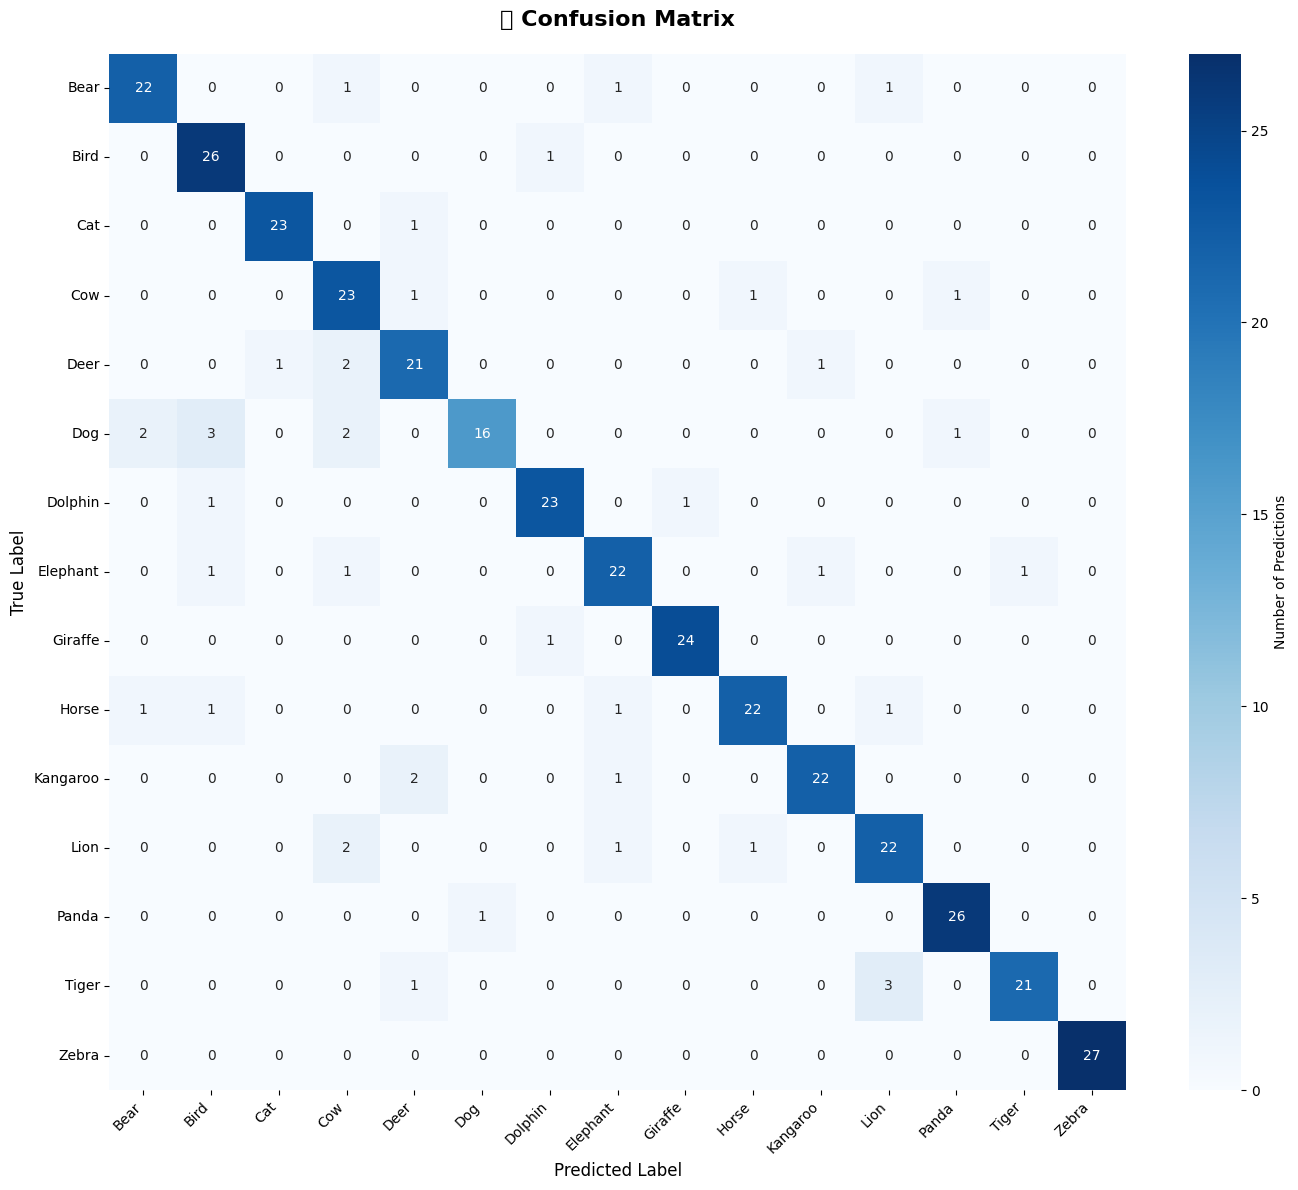

In [15]:
# Cell 13: Evaluate Model Performance
def evaluate_colab_model(model, val_generator):
    """Comprehensive model evaluation for Colab"""

    print("🔍 Evaluating model performance...")

    # Basic evaluation
    val_loss, val_accuracy = model.evaluate(val_generator, verbose=0)
    print(f"✅ Validation Accuracy: {val_accuracy:.4f}")
    print(f"📉 Validation Loss: {val_loss:.4f}")

    # Detailed predictions
    val_generator.reset()
    print("🔄 Generating predictions...")
    predictions = model.predict(val_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    true_classes = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=class_labels))

    # Enhanced confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_labels, yticklabels=class_labels,
               cbar_kws={'label': 'Number of Predictions'})
    plt.title('🎯 Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return val_accuracy, val_loss

# Evaluate the model
if DATASET_PATH:
    final_acc, final_loss = evaluate_colab_model(model, val_generator)

In [16]:
# Cell 14: Save Model in Colab
def save_colab_model(model, class_indices, drive_save=True):
    """Save model and download or save to Drive"""

    # Save model locally in Colab
    model_path = '/content/animal_classifier_final.h5'
    model.save(model_path)
    print(f"✅ Model saved locally: {model_path}")

    # Save class names
    class_names = list(class_indices.keys())
    with open('/content/class_names.pkl', 'wb') as f:
        pickle.dump(class_names, f)
    print("✅ Class names saved: /content/class_names.pkl")

    # Option 1: Save to Google Drive
    if drive_save:
        try:
            shutil.copy(model_path, '/content/drive/MyDrive/animal_classifier_final.h5')
            shutil.copy('/content/class_names.pkl', '/content/drive/MyDrive/class_names.pkl')
            print("✅ Model and class names saved to Google Drive!")
        except Exception as e:
            print(f"⚠️  Could not save to Drive: {e}")

    # Option 2: Download files
    print("📥 Downloading model files...")
    files.download(model_path)
    files.download('/content/class_names.pkl')

    print("🎉 Model saved successfully!")

# Save the model
if DATASET_PATH:
    save_colab_model(model, train_generator.class_indices)

✅ Model saved locally: /content/animal_classifier_final.h5
✅ Class names saved: /content/class_names.pkl
✅ Model and class names saved to Google Drive!
📥 Downloading model files...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎉 Model saved successfully!


In [17]:
# Cell 15: Test Prediction Function
def test_prediction_colab(model, class_names, image_path):
    """Test prediction on a single image in Colab"""
    try:
        # Load and preprocess image
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx]

        predicted_animal = class_names[predicted_class_idx]

        # Display results
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(f'🎯 Predicted: {predicted_animal}\n📊 Confidence: {confidence:.2%}',
                 fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.show()

        # Show top 3 predictions
        top_3_idx = np.argsort(predictions[0])[::-1][:3]
        print("🏆 Top 3 predictions:")
        for i, idx in enumerate(top_3_idx):
            medal = ["🥇", "🥈", "🥉"][i]
            print(f"{medal} {class_names[idx]}: {predictions[0][idx]:.2%}")

        return predicted_animal, confidence

    except Exception as e:
        print(f"❌ Error: {str(e)}")
        return None, None

print("🎉 All done! The model is trained and ready!")
print("\n📋 Summary of files created:")
print("   🤖 animal_classifier_final.h5 - Your trained model")
print("   📝 class_names.pkl - Class names for prediction")
print("\n🧪 To test a prediction, use:")
print("test_prediction_colab(model, list(train_generator.class_indices.keys()), 'path_to_test_image.jpg')")

🎉 All done! Your model is trained and ready!

📋 Summary of files created:
   🤖 animal_classifier_final.h5 - Your trained model
   📝 class_names.pkl - Class names for prediction

🧪 To test a prediction, use:
test_prediction_colab(model, list(train_generator.class_indices.keys()), 'path_to_test_image.jpg')


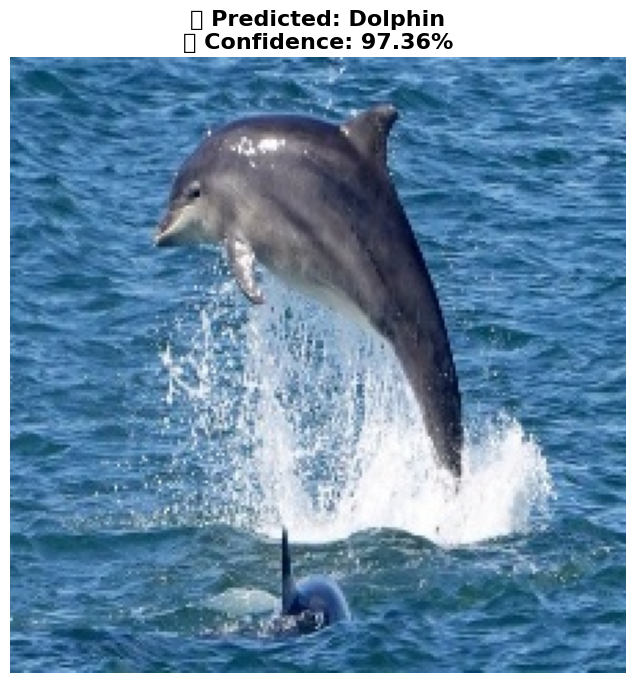

🏆 Top 3 predictions:
🥇 Dolphin: 97.36%
🥈 Cow: 0.46%
🥉 Kangaroo: 0.35%


('Dolphin', np.float32(0.9736457))

In [18]:
test_prediction_colab(model, list(train_generator.class_indices.keys()), '/content/dataset/Dolphin/Dolphin_10_1.jpg')

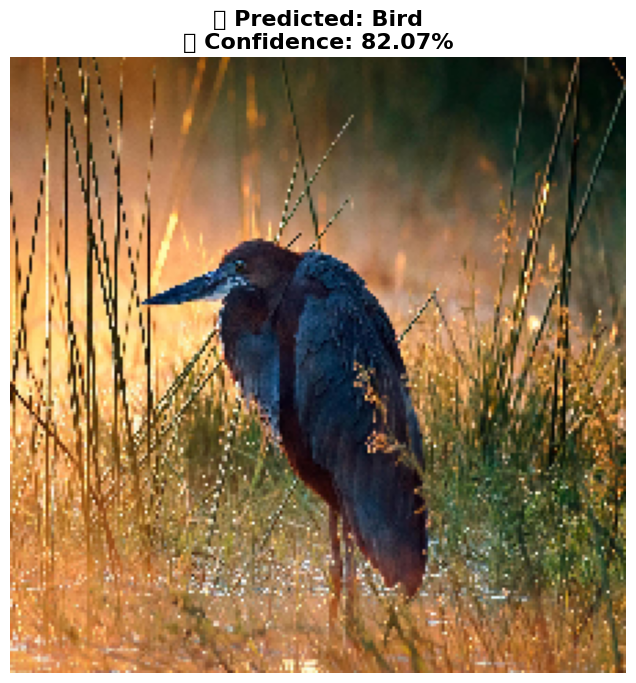

🏆 Top 3 predictions:
🥇 Bird: 82.07%
🥈 Cow: 7.02%
🥉 Horse: 5.51%


('Bird', np.float32(0.8207422))

In [19]:
test_prediction_colab(model, list(train_generator.class_indices.keys()), '/content/birdImageFromOutsideDatasetForTesting.png')